# Combined Tier 1 Paradigms: Deep Research Agent

This notebook implements the **Combined Tier 1 Architecture** that unifies four paradigms:

1. **Cascading Knowledge Cache** - Global search layer wrapping all operations
2. **Agile Sprints** - Information gathering with retrospectives
3. **Iterative Refinement V2** - Skeleton-based document generation with patches
4. **Quality Gates** - Strategic checkpoints for quality assurance

## Architecture Overview

The architecture follows a **funnel pattern**:
```
Wide Research → Structured Synthesis → Focused Refinement → Polished Output
```

### Five Phases:
1. **Phase 1: Agile Research Sprints** - Comprehensive information gathering
2. **Phase 2: Skeleton Generation** - Create document structure
3. **Phase 3: Node Expansion** - Generate prose per section
4. **Phase 4: Verification & Refinement** - Quality gates and patching
5. **Phase 5: Final Assembly** - Compile polished report

## Technology Stack
- **LLM**: gpt-5-mini-2025-08-07
- **Web Search**: Tavily API
- **Embeddings**: OpenAI text-embedding-3-small
- **Tracing**: LangSmith
- **Framework**: LangGraph

## 1. Setup and Configuration

In [4]:
import os
import operator
import asyncio
import hashlib
import re
import json
from pathlib import Path
from typing import List, Dict, Tuple, Annotated, TypedDict, Literal, Optional, Any
from urllib.parse import urlparse
from datetime import datetime

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from tavily import TavilyClient

from langgraph.graph import StateGraph, START, END

import numpy as np

# Load environment variables
env_path = Path("../.env")
load_dotenv(env_path)

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

Environment configured successfully


In [4]:
# Initialize LLM, Tavily, and Embeddings
MODEL_NAME = "gpt-5-mini-2025-08-07"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0, max_retries=10)
tavily_client = TavilyClient()
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# ===== CONFIGURATION PARAMETERS =====

# Research Phase (Agile Sprints)
MAX_RESEARCH_SPRINTS = 3
QUERIES_PER_SPRINT = 5
MIN_SOURCES_FOR_GATE1 = 15
MIN_DOMAINS_FOR_GATE1 = 5

# Skeleton Generation
TARGET_WORDS_PER_NODE = 300
MIN_SECTIONS = 5
MAX_SECTIONS = 8

# Knowledge Cache
CHUNK_SIZE = 500
CHUNK_OVERLAP = 100
HIGH_CONFIDENCE_THRESHOLD = 0.75
LOW_CONFIDENCE_THRESHOLD = 0.40
SPECIFICITY_ADJUSTMENT = 0.2
TOP_K_RETRIEVAL = 5

# Verification & Refinement
MAX_REFINEMENT_ITERATIONS = 2
QUALITY_THRESHOLD = 7.5
MIN_EVIDENCE_SCORE = 6
MAX_CASCADES_PER_ITERATION = 5

# Token Management
MAX_CONTEXT_CHARS = 12000
MAX_FINDINGS_CHARS = 10000

print(f"Using model: {MODEL_NAME}")
print(f"Research: max {MAX_RESEARCH_SPRINTS} sprints, {QUERIES_PER_SPRINT} queries/sprint")
print(f"Refinement: max {MAX_REFINEMENT_ITERATIONS} iterations, threshold {QUALITY_THRESHOLD}/10")
print(f"Cache: HIGH >= {HIGH_CONFIDENCE_THRESHOLD}, LOW < {LOW_CONFIDENCE_THRESHOLD}")

Using model: gpt-5-mini-2025-08-07
Research: max 3 sprints, 5 queries/sprint
Refinement: max 2 iterations, threshold 7.5/10
Cache: HIGH >= 0.75, LOW < 0.4


## 2. Knowledge Cache Implementation

The Knowledge Cache wraps ALL search operations throughout the agent, providing:
- **Layer 1**: Deterministic deduplication (exact query match)
- **Layer 2**: Semantic similarity retrieval (vector search)
- **Layer 3**: LLM-augmented judgment (gap analysis)

In [5]:
# ===== Knowledge Cache Data Models =====

class CachedDocument(BaseModel):
    """A cached web document."""
    url: str
    normalized_url: str
    content: str
    content_hash: str
    title: str = ""
    retrieval_timestamp: str
    source_query: str = ""


class CachedChunk(BaseModel):
    """A chunk of content with embedding."""
    chunk_id: str
    text: str
    embedding: List[float]
    source_url: str
    position: int


class CacheDecision(BaseModel):
    """Record of a cache decision for observability."""
    query: str
    layer_reached: Literal["L1", "L2", "L3"]
    decision: str
    confidence_score: float = 0.0
    action_taken: Literal["USE_CACHE", "SEARCH", "TARGETED_SEARCH"]
    reasoning: str = ""
    timestamp: str = ""


class KnowledgeBase:
    """Session-scoped knowledge base with cascading cache capabilities."""

    def __init__(self):
        self.url_registry: Dict[str, CachedDocument] = {}
        self.query_cache: Dict[str, dict] = {}
        self.chunks: List[CachedChunk] = []
        self.chunk_embeddings: Optional[np.ndarray] = None
        self.stats = {
            "total_queries": 0, "l1_hits": 0, "l2_high": 0, "l2_medium": 0,
            "l2_low": 0, "l3_sufficient": 0, "l3_partial": 0, "l3_insufficient": 0,
            "web_searches_executed": 0, "web_searches_avoided": 0
        }

    def normalize_url(self, url: str) -> str:
        try:
            parsed = urlparse(url)
            host = parsed.netloc.lower()
            if host.startswith("www."):
                host = host[4:]
            path = parsed.path.rstrip("/")
            return f"https://{host}{path}"
        except:
            return url.lower()

    def normalize_query_light(self, query: str) -> str:
        return " ".join(query.lower().split())

    def normalize_query_aggressive(self, query: str) -> str:
        stop_words = {"the", "a", "an", "is", "are", "of", "in", "to", "for", "and", "or", "what", "how", "why"}
        light = self.normalize_query_light(query)
        terms = [t for t in light.split() if t not in stop_words and len(t) > 1]
        return " ".join(sorted(terms))

    def compute_content_hash(self, content: str) -> str:
        return hashlib.sha256(content.encode()).hexdigest()

    def add_document(self, url: str, content: str, title: str = "", source_query: str = ""):
        normalized_url = self.normalize_url(url)
        doc = CachedDocument(
            url=url, normalized_url=normalized_url, content=content,
            content_hash=self.compute_content_hash(content), title=title,
            retrieval_timestamp=datetime.now().isoformat(), source_query=source_query
        )
        self.url_registry[normalized_url] = doc
        self._chunk_and_embed(doc)
        return doc

    def _chunk_and_embed(self, doc: CachedDocument):
        content = doc.content
        chunks_text = []
        for i in range(0, len(content), CHUNK_SIZE - CHUNK_OVERLAP):
            chunk_text = content[i:i + CHUNK_SIZE]
            if len(chunk_text) > 50:
                chunks_text.append(chunk_text)
        if not chunks_text:
            return
        embeddings = embeddings_model.embed_documents(chunks_text)
        for i, (text, embedding) in enumerate(zip(chunks_text, embeddings)):
            chunk = CachedChunk(
                chunk_id=f"{doc.content_hash[:8]}_{i}", text=text,
                embedding=embedding, source_url=doc.url, position=i
            )
            self.chunks.append(chunk)
        self._update_embedding_matrix()

    def _update_embedding_matrix(self):
        if self.chunks:
            self.chunk_embeddings = np.array([c.embedding for c in self.chunks])

    def add_query(self, query: str, result_urls: List[str], result_summary: str):
        entry = {
            "original_query": query, "light_normalized": self.normalize_query_light(query),
            "aggressive_normalized": self.normalize_query_aggressive(query),
            "timestamp": datetime.now().isoformat(), "result_urls": result_urls,
            "result_summary": result_summary
        }
        self.query_cache[entry["light_normalized"]] = entry
        self.query_cache[entry["aggressive_normalized"]] = entry
        return entry

    def lookup_query_exact(self, query: str) -> Optional[dict]:
        return self.query_cache.get(self.normalize_query_light(query))

    def semantic_search(self, query: str, top_k: int = TOP_K_RETRIEVAL) -> List[Tuple[CachedChunk, float]]:
        if not self.chunks or self.chunk_embeddings is None:
            return []
        query_embedding = np.array(embeddings_model.embed_query(query))
        similarities = np.dot(self.chunk_embeddings, query_embedding) / (
            np.linalg.norm(self.chunk_embeddings, axis=1) * np.linalg.norm(query_embedding) + 1e-8
        )
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        return [(self.chunks[idx], float(similarities[idx])) for idx in top_indices]

    def get_stats_summary(self) -> str:
        total = self.stats["total_queries"]
        if total == 0:
            return "No queries processed yet."
        avoided = self.stats["web_searches_avoided"]
        hit_rate = avoided / total * 100 if total > 0 else 0
        return f"Total: {total} queries, {avoided} avoided ({hit_rate:.1f}% hit rate), {len(self.chunks)} chunks cached"


# Initialize global knowledge base
knowledge_base = KnowledgeBase()
print("Knowledge base initialized")

Knowledge base initialized


In [6]:
# ===== Cascaded Search Function =====

def search_web(query: str, max_results: int = 8) -> Tuple[str, List[str], List[str]]:
    """Execute web search using Tavily. Returns (summary, results, urls)."""
    try:
        if len(query) > 400:
            query = query[:400]
        response = tavily_client.search(query=query, max_results=max_results, include_answer=True)
        results = []
        urls = []
        summary = response.get("answer", "")
        for r in response.get("results", []):
            url = r.get('url', '')
            urls.append(url)
            content = r.get('content', '')[:500]
            title = r.get('title', 'No title')
            results.append(f"[{title}] {content}... (Source: {url})")
        return summary, results, urls
    except Exception as e:
        return f"Search error: {str(e)}", [], []


def compute_confidence(top_results: List[Tuple[CachedChunk, float]], query: str) -> float:
    """Compute multi-signal confidence score."""
    if not top_results:
        return 0.0
    top_score = top_results[0][1]
    score_gap = top_results[0][1] - top_results[1][1] if len(top_results) > 1 else top_score
    query_terms = set(query.lower().split())
    top_chunk_terms = set(top_results[0][0].text.lower().split())
    term_overlap = len(query_terms & top_chunk_terms) / len(query_terms | top_chunk_terms) if query_terms | top_chunk_terms else 0
    return 0.5 * top_score + 0.25 * min(score_gap * 2, 1.0) + 0.25 * term_overlap


async def cascaded_search(query: str, kb: KnowledgeBase) -> Tuple[str, List[str], CacheDecision]:
    """Execute full cascading cache check and search if needed."""
    kb.stats["total_queries"] += 1
    timestamp = datetime.now().isoformat()

    # Layer 1: Exact match
    exact_match = kb.lookup_query_exact(query)
    if exact_match:
        kb.stats["l1_hits"] += 1
        kb.stats["web_searches_avoided"] += 1
        return exact_match["result_summary"], exact_match["result_urls"], CacheDecision(
            query=query, layer_reached="L1", decision="HIT", confidence_score=1.0,
            action_taken="USE_CACHE", reasoning="Exact query match", timestamp=timestamp
        )

    # Layer 2: Semantic search
    results = kb.semantic_search(query)
    if results:
        confidence = compute_confidence(results, query)
        if confidence >= HIGH_CONFIDENCE_THRESHOLD:
            kb.stats["l2_high"] += 1
            kb.stats["web_searches_avoided"] += 1
            content = "\n\n".join([f"[From: {c.source_url}]\n{c.text}" for c, _ in results[:3]])
            urls = list(set([c.source_url for c, _ in results]))
            return content, urls, CacheDecision(
                query=query, layer_reached="L2", decision="HIGH_CONF", confidence_score=confidence,
                action_taken="USE_CACHE", reasoning=f"High semantic similarity ({confidence:.2f})", timestamp=timestamp
            )
        elif confidence >= LOW_CONFIDENCE_THRESHOLD:
            kb.stats["l2_medium"] += 1
            # For medium confidence, still do a search but could use cached context
        else:
            kb.stats["l2_low"] += 1

    # Execute web search
    summary, search_results, urls = search_web(query)
    kb.stats["web_searches_executed"] += 1

    # Cache results
    query_content = f"Query: {query}\n\nAnswer: {summary}\n\nResults:\n" + "\n\n".join(search_results)
    synthetic_url = f"search://{kb.compute_content_hash(query)[:16]}"
    kb.add_document(synthetic_url, query_content, title=f"Search: {query[:50]}", source_query=query)
    kb.add_query(query, urls, summary)

    return query_content, urls, CacheDecision(
        query=query, layer_reached="L2", decision="LOW_CONF",
        confidence_score=compute_confidence(results, query) if results else 0.0,
        action_taken="SEARCH", reasoning="Executed web search", timestamp=timestamp
    )


print("Cascaded search function defined")

Cascaded search function defined


## 3. State Definition and Data Models

In [7]:
# ===== Skeleton and Prose Models =====

class SkeletonNode(BaseModel):
    """A node in the document skeleton hierarchy."""
    node_id: str = Field(description="Unique identifier like 'sec:intro'")
    title: str = Field(description="Section title")
    intent: str = Field(description="1-3 sentence description of purpose")
    target_word_count: int = Field(default=300)
    dependencies: List[str] = Field(default_factory=list)
    children: List[str] = Field(default_factory=list)
    is_expanded: bool = Field(default=False)


class SkeletonGenerationOutput(BaseModel):
    """Output schema for skeleton generation."""
    thesis: str = Field(description="One-sentence thesis statement")
    sections: List[SkeletonNode] = Field(description="All sections in document order")


class ProseGenerationOutput(BaseModel):
    """Output schema for prose generation."""
    bridge_in: str = Field(description="Transitional sentences from previous section")
    main_content: str = Field(description="Main prose content")
    bridge_out: str = Field(description="Transitional sentences to next section")
    summary: str = Field(description="1-2 sentence summary")


class Claim(BaseModel):
    """A verifiable assertion in the document."""
    claim_id: str
    claim_text: str
    source_node: str
    verification_status: Literal["unverified", "verified", "contested"] = "unverified"
    supporting_evidence: List[str] = Field(default_factory=list)


class ClaimExtractionOutput(BaseModel):
    """Output for claim extraction."""
    claims: List[Claim]


class CritiqueIssue(BaseModel):
    """An issue identified during critique."""
    issue_id: str
    scope: Literal["global", "section", "transition"]
    target_nodes: List[str]
    issue_type: str
    severity: Literal["critical", "major", "minor"]
    description: str
    suggestion: str
    search_query: str = ""


class CritiqueResult(BaseModel):
    """Complete critique output."""
    overall_quality: float = Field(description="Quality score 1-10")
    issues: List[CritiqueIssue] = Field(default_factory=list)
    summary: str


print("Data models defined")

Data models defined


In [8]:
# ===== Combined Tier 1 State =====

class CombinedTier1State(TypedDict):
    """State for the Combined Tier 1 Deep Research Agent."""
    # Input
    question: str

    # ===== PHASE 1: Research Sprints =====
    research_backlog: List[str]  # REPLACED each sprint
    current_research_sprint: int
    max_research_sprints: int
    sprint_findings: Annotated[List[str], operator.add]  # ACCUMULATED
    research_source_urls: Annotated[List[str], operator.add]
    research_retrospective_notes: Annotated[List[str], operator.add]
    research_summary: str
    research_complete: bool

    # ===== PHASE 2: Skeleton =====
    skeleton: Dict[str, Any]
    skeleton_validated: bool

    # ===== PHASE 3: Node Expansion =====
    prose_store: Dict[str, Dict[str, Any]]
    claims_registry: Dict[str, Dict[str, Any]]
    nodes_expanded: List[str]

    # ===== PHASE 4: Verification =====
    noise_map: List[Dict[str, Any]]
    nodes_to_patch: List[str]
    cascade_queue: List[str]
    targeted_evidence: Dict[str, List[str]]
    current_refinement_iteration: int
    max_refinement_iterations: int
    quality_scores: Annotated[List[float], operator.add]
    verification_log: Annotated[List[str], operator.add]

    # ===== PHASE 5: Output =====
    final_report: str

    # ===== METRICS =====
    total_searches: int
    cache_hits: int
    cache_decisions: Annotated[List[Dict], operator.add]


print("Combined state defined")

Combined state defined


## 4. Phase 1: Agile Research Sprints

This phase decomposes the question, executes sprints with retrospectives, and produces a compressed research brief.

In [9]:
# ===== Phase 1 Prompts =====

DECOMPOSE_PROMPT = """You are a research planning expert. Decompose this research question into 5-7 specific sub-questions.

Research Question: {question}

Generate a prioritized list of specific, focused research questions that together will comprehensively answer the main question. Each should be independently searchable.

Return as a numbered list (highest priority first):
1. [Most critical sub-question]
2. [Second priority]
...
"""

SPRINT_SYNTHESIS_PROMPT = """You are a research agent conducting Sprint {sprint_num} of {max_sprints}.

Current research focus: {current_questions}

Based on the search results below, extract key findings addressing these questions.
Be specific and cite sources with URLs.

Search Results:
{search_results}

Provide a comprehensive summary of findings (400-600 words) with specific facts and source URLs.
"""

RETROSPECTIVE_PROMPT = """You are conducting a sprint retrospective for a research project.

Original Question: {original_question}

Sprint {sprint_num} of {max_sprints} has completed.

Summary of findings so far:
{findings_summary}

Current remaining questions:
{remaining_backlog}

Provide a STRUCTURED response:

## LEARNINGS
Key insights from this sprint.

## GAPS
What is still unclear or needs investigation?

## CONTINUE
Should we continue with another sprint? Answer YES or NO.

## NEW_QUESTIONS
List 2-4 NEW questions that emerged (or "None"):
- [New question 1]
- [New question 2]

## REPRIORITIZED_BACKLOG
Reorder remaining questions by priority:
1. [Highest priority]
2. [Next priority]
...
"""

COMPRESS_FINDINGS_PROMPT = """Summarize these research findings into a concise research brief.

All Findings:
{all_findings}

Create a bullet-point summary (max 600 words) capturing:
- Key facts and statistics
- Main themes and patterns
- Important sources
- Any contradictions identified

Be concise but preserve critical information.
"""

print("Phase 1 prompts defined")

Phase 1 prompts defined


In [10]:
# ===== Phase 1 Node Functions =====

async def decompose_question(state: CombinedTier1State) -> dict:
    """Decompose the research question into a backlog of sub-questions."""
    question = state["question"]
    
    print(f"\n{'='*60}")
    print("Phase 1a: Question Decomposition")
    print(f"{'='*60}")
    
    prompt = DECOMPOSE_PROMPT.format(question=question)
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    
    lines = response.content.strip().split("\n")
    backlog = []
    for line in lines:
        line = line.strip()
        if line and (line[0].isdigit() or line.startswith("-")):
            clean = line.lstrip("0123456789.-) ").strip()
            if clean:
                backlog.append(clean)
    
    print(f"  Created backlog with {len(backlog)} research questions")
    for i, q in enumerate(backlog[:5], 1):
        print(f"    {i}. {q[:60]}...")
    
    return {
        "research_backlog": backlog,
        "current_research_sprint": 1,
        "max_research_sprints": MAX_RESEARCH_SPRINTS,
        "research_complete": False
    }


async def execute_research_sprint(state: CombinedTier1State) -> dict:
    """Execute a research sprint on top backlog items."""
    backlog = state.get("research_backlog", [])
    current_sprint = state.get("current_research_sprint", 1)
    max_sprints = state.get("max_research_sprints", MAX_RESEARCH_SPRINTS)
    
    print(f"\n{'='*60}")
    print(f"Phase 1b: Research Sprint {current_sprint}/{max_sprints}")
    print(f"{'='*60}")
    
    if not backlog:
        return {"sprint_findings": ["No questions in backlog."]}
    
    # Take top questions for this sprint
    current_questions = backlog[:QUERIES_PER_SPRINT]
    
    all_content = []
    all_urls = []
    all_decisions = []
    
    for i, question in enumerate(current_questions, 1):
        print(f"  [{i}/{len(current_questions)}] {question[:50]}...")
        content, urls, decision = await cascaded_search(question, knowledge_base)
        all_content.append(f"### {question}\n{content}")
        all_urls.extend(urls)
        all_decisions.append(decision.model_dump())
        
        action = "CACHE" if decision.action_taken == "USE_CACHE" else "SEARCH"
        print(f"      {action} | Layer: {decision.layer_reached}")
    
    # Synthesize findings
    combined_results = "\n\n---\n\n".join(all_content)
    if len(combined_results) > 12000:
        combined_results = combined_results[:12000] + "\n...[truncated]"
    
    synthesis_prompt = SPRINT_SYNTHESIS_PROMPT.format(
        sprint_num=current_sprint,
        max_sprints=max_sprints,
        current_questions="\n".join(f"- {q}" for q in current_questions),
        search_results=combined_results
    )
    
    synthesis = await llm.ainvoke([HumanMessage(content=synthesis_prompt)])
    finding = f"## Sprint {current_sprint} Findings\n\n{synthesis.content}"
    
    # Update backlog (remove processed questions)
    updated_backlog = backlog[QUERIES_PER_SPRINT:]
    
    print(f"  Synthesized {len(synthesis.content)} chars, {len(all_urls)} sources")
    
    return {
        "sprint_findings": [finding],
        "research_source_urls": all_urls,
        "cache_decisions": all_decisions,
        "research_backlog": updated_backlog
    }


print("Phase 1 node functions defined (part 1)")

Phase 1 node functions defined (part 1)


In [11]:
# ===== Phase 1 Node Functions (continued) =====

def parse_reprioritized_backlog(response_content: str) -> List[str]:
    """Parse reprioritized backlog from retrospective."""
    backlog_match = re.search(r'## REPRIORITIZED_BACKLOG\s*(.*?)(?=##|$)', response_content, re.DOTALL | re.IGNORECASE)
    if backlog_match:
        backlog_text = backlog_match.group(1)
        questions = []
        for line in backlog_text.strip().split("\n"):
            line = line.strip()
            if line and (line[0].isdigit() or line.startswith("-")):
                clean = re.sub(r'^[\d\.\-\)\s]+', '', line).strip()
                if clean and len(clean) > 10:
                    questions.append(clean)
        return questions
    return []


def parse_should_continue_research(response_content: str) -> bool:
    """Parse whether to continue from retrospective."""
    continue_match = re.search(r'## CONTINUE\s*(.*?)(?=##|$)', response_content, re.DOTALL | re.IGNORECASE)
    if continue_match:
        text = continue_match.group(1).strip().lower()
        negative_patterns = [r'^no\b', r'should\s+stop', r'sufficient', r'adequately']
        for pattern in negative_patterns:
            if re.search(pattern, text):
                return False
    return True


async def research_retrospective(state: CombinedTier1State) -> dict:
    """Conduct retrospective after research sprint."""
    question = state["question"]
    current_sprint = state.get("current_research_sprint", 1)
    max_sprints = state.get("max_research_sprints", MAX_RESEARCH_SPRINTS)
    all_findings = "\n\n".join(state.get("sprint_findings", []))
    backlog = state.get("research_backlog", [])
    
    print(f"\n{'='*60}")
    print(f"Phase 1c: Sprint {current_sprint} Retrospective")
    print(f"{'='*60}")
    
    # Summarize findings for token efficiency
    if len(all_findings) > 4000:
        compress_prompt = COMPRESS_FINDINGS_PROMPT.format(all_findings=all_findings[:8000])
        compress_response = await llm.ainvoke([HumanMessage(content=compress_prompt)])
        findings_summary = compress_response.content
    else:
        findings_summary = all_findings
    
    prompt = RETROSPECTIVE_PROMPT.format(
        original_question=question,
        sprint_num=current_sprint,
        max_sprints=max_sprints,
        findings_summary=findings_summary,
        remaining_backlog="\n".join(f"- {q}" for q in backlog) if backlog else "None"
    )
    
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    
    reprioritized = parse_reprioritized_backlog(response.content)
    should_continue = parse_should_continue_research(response.content)
    
    if not reprioritized and backlog:
        reprioritized = backlog
    
    print(f"  Should continue: {should_continue}")
    print(f"  Backlog size: {len(reprioritized)}")
    
    return {
        "research_retrospective_notes": [f"### Sprint {current_sprint} Retrospective\n{response.content}"],
        "current_research_sprint": current_sprint + 1,
        "research_backlog": reprioritized,
        "research_summary": findings_summary,
        "research_complete": not should_continue
    }


async def quality_gate_1(state: CombinedTier1State) -> dict:
    """Check source sufficiency before moving to synthesis."""
    source_urls = state.get("research_source_urls", [])
    unique_urls = list(set(source_urls))
    
    # Count unique domains
    domains = set()
    for url in unique_urls:
        try:
            parsed = urlparse(url)
            domains.add(parsed.netloc)
        except:
            pass
    
    print(f"\n{'='*60}")
    print("Quality Gate 1: Source Sufficiency")
    print(f"{'='*60}")
    print(f"  Unique sources: {len(unique_urls)} (min: {MIN_SOURCES_FOR_GATE1})")
    print(f"  Unique domains: {len(domains)} (min: {MIN_DOMAINS_FOR_GATE1})")
    
    passed = len(unique_urls) >= MIN_SOURCES_FOR_GATE1 and len(domains) >= MIN_DOMAINS_FOR_GATE1
    print(f"  Gate 1 {'PASSED' if passed else 'PASSED (relaxed)'}")  # Always pass but note
    
    return {"research_complete": True}


async def compress_findings(state: CombinedTier1State) -> dict:
    """Compress all findings into a research brief for skeleton generation."""
    all_findings = "\n\n".join(state.get("sprint_findings", []))
    
    print(f"\n{'='*60}")
    print("Phase 1d: Compressing Research Brief")
    print(f"{'='*60}")
    
    if len(all_findings) > MAX_FINDINGS_CHARS:
        prompt = COMPRESS_FINDINGS_PROMPT.format(all_findings=all_findings[:MAX_FINDINGS_CHARS])
        response = await llm.ainvoke([HumanMessage(content=prompt)])
        summary = response.content
    else:
        summary = all_findings
    
    print(f"  Compressed to {len(summary)} chars")
    
    return {"research_summary": summary}


def should_continue_research(state: CombinedTier1State) -> Literal["execute_sprint", "quality_gate_1"]:
    """Decide whether to continue research or move to quality gate."""
    current_sprint = state.get("current_research_sprint", 1)
    max_sprints = state.get("max_research_sprints", MAX_RESEARCH_SPRINTS)
    backlog = state.get("research_backlog", [])
    research_complete = state.get("research_complete", False)
    
    if current_sprint > max_sprints:
        print(f"  Max sprints reached. Moving to Quality Gate 1.")
        return "quality_gate_1"
    if not backlog:
        print(f"  Backlog empty. Moving to Quality Gate 1.")
        return "quality_gate_1"
    if research_complete:
        print(f"  Research marked complete. Moving to Quality Gate 1.")
        return "quality_gate_1"
    
    print(f"  Continuing to sprint {current_sprint}.")
    return "execute_sprint"


print("Phase 1 node functions defined (part 2)")

Phase 1 node functions defined (part 2)


## 5. Phase 2: Skeleton Generation

Creates a hierarchical document structure before writing prose.

In [12]:
# ===== Phase 2: Skeleton Generation =====

SKELETON_PROMPT = """You are a research document architect. Create a document skeleton.

Research Question: {question}

Research Findings Summary:
{research_summary}

Create a hierarchical document structure with:
1. A thesis statement (one sentence)
2. 5-7 main sections for a comprehensive research report

Each section needs:
- node_id: Unique identifier like "sec:intro", "sec:background"
- title: Descriptive section title
- intent: 1-3 sentences describing what this section accomplishes
- target_word_count: 250-400 words per section
- dependencies: List of node_ids this section builds upon (empty for intro)
- children: Empty list (flat structure)

REQUIRED SECTIONS:
1. Introduction - Present topic, context, thesis
2. Background - Foundation knowledge
3. Main Body (2-4 sections) - Key aspects in depth
4. Analysis/Discussion - Synthesize findings
5. Conclusion - Summary and future directions

Node IDs must be unique. Dependencies must reference existing nodes only.
"""


def validate_skeleton(skeleton: Dict[str, Any]) -> Tuple[bool, List[str]]:
    """Validate skeleton structure."""
    issues = []
    nodes = skeleton.get("nodes", {})
    root_nodes = skeleton.get("root_nodes", [])
    
    for root_id in root_nodes:
        if root_id not in nodes:
            issues.append(f"Root node '{root_id}' not found")
    
    for node_id, node in nodes.items():
        for dep_id in node.get("dependencies", []):
            if dep_id not in nodes:
                issues.append(f"Node '{node_id}' depends on non-existent '{dep_id}'")
    
    return len(issues) == 0, issues


async def generate_skeleton(state: CombinedTier1State) -> dict:
    """Generate the document skeleton structure."""
    question = state["question"]
    research_summary = state.get("research_summary", "")
    
    print(f"\n{'='*60}")
    print("Phase 2: Skeleton Generation")
    print(f"{'='*60}")
    
    prompt = SKELETON_PROMPT.format(question=question, research_summary=research_summary[:6000])
    
    structured_llm = llm.with_structured_output(SkeletonGenerationOutput)
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    # Build skeleton dictionary
    skeleton = {
        "thesis": result.thesis,
        "root_nodes": [],
        "nodes": {}
    }
    
    child_ids = set()
    for section in result.sections:
        child_ids.update(section.children)
    
    for section in result.sections:
        skeleton["nodes"][section.node_id] = section.model_dump()
        if section.node_id not in child_ids:
            skeleton["root_nodes"].append(section.node_id)
    
    if not skeleton["root_nodes"]:
        skeleton["root_nodes"] = list(skeleton["nodes"].keys())
    
    is_valid, issues = validate_skeleton(skeleton)
    
    print(f"  Thesis: {result.thesis[:80]}...")
    print(f"  Sections: {len(skeleton['nodes'])}")
    print(f"  Valid: {is_valid}")
    if issues:
        for issue in issues[:3]:
            print(f"    Warning: {issue}")
    
    return {
        "skeleton": skeleton,
        "skeleton_validated": is_valid,
        "prose_store": {},
        "claims_registry": {}
    }


print("Phase 2 functions defined")

Phase 2 functions defined


## 6. Phase 3: Node Expansion

Generates prose for each skeleton node with dependency awareness and bridge sentences.

In [13]:
# ===== Phase 3: Node Expansion =====

PROSE_PROMPT = """You are a research writer generating content for a specific section.

DOCUMENT CONTEXT:
Research Question: {question}
Document Thesis: {thesis}

SECTION TO WRITE:
Node ID: {node_id}
Title: {title}
Intent: {intent}
Target Length: ~{target_words} words

PREVIOUS SECTION ENDING:
{previous_bridge_out}

DEPENDENCY SUMMARIES:
{dependency_summaries}

RESEARCH FINDINGS:
{research_findings}

REQUIREMENTS:
1. bridge_in (1-2 sentences): Transition from previous section
2. main_content (~{target_words} words): Substantive prose with citations (Source: URL)
3. bridge_out (1-2 sentences): Transition to next section
4. summary (1-2 sentences): What this section establishes

Be comprehensive, specific, and well-sourced.
"""


def get_leaf_nodes(skeleton: Dict[str, Any]) -> List[str]:
    """Get all leaf node IDs in document order."""
    nodes = skeleton.get("nodes", {})
    root_nodes = skeleton.get("root_nodes", [])
    
    def collect_leaves(node_ids: List[str]) -> List[str]:
        leaves = []
        for nid in node_ids:
            node = nodes.get(nid, {})
            children = node.get("children", [])
            if not children:
                leaves.append(nid)
            else:
                leaves.extend(collect_leaves(children))
        return leaves
    
    return collect_leaves(root_nodes)


def topological_sort_nodes(skeleton: Dict[str, Any], node_ids: List[str]) -> List[str]:
    """Sort nodes by dependency order."""
    nodes = skeleton.get("nodes", {})
    node_id_set = set(node_ids)
    remaining = set(node_ids)
    sorted_nodes = []
    
    while remaining:
        ready = []
        for nid in remaining:
            node = nodes.get(nid, {})
            deps = set(node.get("dependencies", []))
            internal_deps = deps & node_id_set
            if internal_deps.issubset(set(sorted_nodes)):
                ready.append(nid)
        
        if not ready:
            # Circular dependency - add remaining in order
            for nid in node_ids:
                if nid in remaining:
                    sorted_nodes.append(nid)
            break
        
        ready_ordered = [nid for nid in node_ids if nid in ready]
        sorted_nodes.extend(ready_ordered)
        remaining -= set(ready_ordered)
    
    return sorted_nodes


async def expand_all_nodes(state: CombinedTier1State) -> dict:
    """Expand all leaf nodes in dependency order."""
    skeleton = state["skeleton"]
    research_summary = state.get("research_summary", "")
    question = state["question"]
    
    print(f"\n{'='*60}")
    print("Phase 3: Node Expansion")
    print(f"{'='*60}")
    
    leaf_nodes = get_leaf_nodes(skeleton)
    sorted_nodes = topological_sort_nodes(skeleton, leaf_nodes)
    
    prose_store = {}
    claims_registry = {}
    
    for i, node_id in enumerate(sorted_nodes):
        node = skeleton["nodes"][node_id]
        print(f"  [{i+1}/{len(sorted_nodes)}] {node_id}: {node['title']}")
        
        # Get previous node's bridge_out
        prev_bridge_out = ""
        if i > 0:
            prev_id = sorted_nodes[i-1]
            if prev_id in prose_store:
                prev_bridge_out = prose_store[prev_id].get("bridge_out", "")
        
        # Get dependency summaries
        dep_summaries = []
        for dep_id in node.get("dependencies", []):
            if dep_id in prose_store:
                dep_title = skeleton["nodes"].get(dep_id, {}).get("title", dep_id)
                dep_summary = prose_store[dep_id].get("summary", "")
                dep_summaries.append(f"{dep_title}: {dep_summary}")
        
        prompt = PROSE_PROMPT.format(
            question=question,
            thesis=skeleton.get("thesis", ""),
            node_id=node_id,
            title=node.get("title", ""),
            intent=node.get("intent", ""),
            target_words=node.get("target_word_count", TARGET_WORDS_PER_NODE),
            previous_bridge_out=prev_bridge_out if prev_bridge_out else "(First section)",
            dependency_summaries="\n".join(dep_summaries) if dep_summaries else "(No dependencies)",
            research_findings=research_summary[:4000]
        )
        
        structured_llm = llm.with_structured_output(ProseGenerationOutput)
        result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
        
        prose_store[node_id] = {
            "node_id": node_id,
            "main_content": result.main_content,
            "bridge_in": result.bridge_in,
            "bridge_out": result.bridge_out,
            "summary": result.summary,
            "revision_count": 0
        }
        
        print(f"      Generated {len(result.main_content)} chars")
    
    return {
        "prose_store": prose_store,
        "claims_registry": claims_registry,
        "nodes_expanded": sorted_nodes
    }


print("Phase 3 functions defined")

Phase 3 functions defined


## 7. Phase 4: Verification and Refinement

Critique the document, apply Quality Gate 2, do targeted retrieval for weak claims, and apply patches.

In [14]:
# ===== Phase 4: Critique and Quality Gate 2 =====

CRITIQUE_PROMPT = """You are a critical reviewer evaluating a research document.

ORIGINAL QUESTION: {question}
DOCUMENT THESIS: {thesis}

FULL DOCUMENT:
{document_content}

Analyze at THREE levels:

## 1. GLOBAL ISSUES (entire document)
- Thesis clarity and consistency
- Overall argument flow
- Terminology consistency

## 2. SECTION ISSUES (per node) - MOST IMPORTANT
- weak_claim: Claims lacking evidence
- missing_evidence: Key assertions needing sources
- logical_gap: Reasoning jumps
- unclear: Ambiguous passages
- depth: Insufficient detail

## 3. TRANSITION ISSUES (between sections)
- Abrupt topic shifts
- Redundant transitions

For each issue provide:
- issue_id: Unique identifier
- scope: "global", "section", or "transition"
- target_nodes: Affected node IDs
- issue_type: Category
- severity: "critical", "major", or "minor"
- description: What the problem is
- suggestion: How to fix it
- search_query: Query to find evidence (for evidence issues)

SCORING (1-10):
- 9-10: Publication ready
- 7-8: Good, minor issues
- 5-6: Needs improvement
- 3-4: Significant problems

Provide overall_quality score and list of issues.
"""


async def critique_document(state: CombinedTier1State) -> dict:
    """Perform structured critique producing the Noise Map."""
    skeleton = state["skeleton"]
    prose_store = state["prose_store"]
    question = state["question"]
    iteration = state.get("current_refinement_iteration", 0)
    
    print(f"\n{'='*60}")
    print(f"Phase 4a: Critique (Iteration {iteration})")
    print(f"{'='*60}")
    
    # Build document content
    leaf_nodes = get_leaf_nodes(skeleton)
    document_content = ""
    for node_id in leaf_nodes:
        if node_id in prose_store:
            node = skeleton["nodes"][node_id]
            prose = prose_store[node_id]
            document_content += f"\n\n## {node['title']} [{node_id}]\n"
            document_content += f"{prose.get('bridge_in', '')}\n"
            document_content += f"{prose.get('main_content', '')}\n"
            document_content += f"{prose.get('bridge_out', '')}\n"
    
    if len(document_content) > 12000:
        document_content = document_content[:12000] + "\n...[truncated]"
    
    prompt = CRITIQUE_PROMPT.format(
        question=question,
        thesis=skeleton.get("thesis", ""),
        document_content=document_content
    )
    
    structured_llm = llm.with_structured_output(CritiqueResult)
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    noise_map = [issue.model_dump() for issue in result.issues]
    
    # Identify nodes needing patches
    nodes_to_patch = list(set(
        node_id for issue in result.issues
        for node_id in issue.target_nodes
        if issue.severity in ["critical", "major"]
    ))
    
    print(f"  Quality Score: {result.overall_quality}/10")
    print(f"  Issues: {len(result.issues)}")
    print(f"  Nodes to patch: {len(nodes_to_patch)}")
    
    return {
        "noise_map": noise_map,
        "nodes_to_patch": nodes_to_patch,
        "quality_scores": [result.overall_quality],
        "current_refinement_iteration": iteration
    }


print("Phase 4 critique defined")

Phase 4 critique defined


In [15]:
# ===== Phase 4: Targeted Retrieval and Patching =====

PATCH_PROMPT = """You are revising a section based on critique feedback.

SECTION TO REVISE:
Node ID: {node_id}
Title: {title}
Intent: {intent}

CURRENT CONTENT:
{current_content}

ISSUES TO FIX:
{issues_text}

NEW EVIDENCE:
{new_evidence}

CONTEXT:
Previous section ends with: {prev_bridge_out}
Next section starts with: {next_bridge_in}

Revise the section to address ALL issues, incorporate evidence with citations.
Output: bridge_in, main_content, bridge_out, summary
"""


async def targeted_retrieval(state: CombinedTier1State) -> dict:
    """Search for evidence to address issues."""
    noise_map = state.get("noise_map", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    
    print(f"\n{'='*60}")
    print("Phase 4b: Targeted Retrieval")
    print(f"{'='*60}")
    
    if not nodes_to_patch:
        print("  No nodes need patching")
        return {"targeted_evidence": {}}
    
    # Collect search queries per node
    node_queries = {}
    for issue in noise_map:
        if issue.get("search_query") and issue.get("severity") in ["critical", "major"]:
            for node_id in issue.get("target_nodes", []):
                if node_id in nodes_to_patch:
                    if node_id not in node_queries:
                        node_queries[node_id] = []
                    node_queries[node_id].append(issue["search_query"])
    
    targeted_evidence = {}
    
    for node_id, queries in node_queries.items():
        print(f"  Searching for: {node_id}")
        node_evidence = []
        for query in queries[:2]:  # Limit queries per node
            print(f"    Query: {query[:40]}...")
            content, urls, decision = await cascaded_search(query, knowledge_base)
            node_evidence.append(content[:1000])
            action = "CACHE" if decision.action_taken == "USE_CACHE" else "SEARCH"
            print(f"      {action} | Layer: {decision.layer_reached}")
        targeted_evidence[node_id] = node_evidence
    
    print(f"  Evidence gathered for {len(targeted_evidence)} nodes")
    
    return {"targeted_evidence": targeted_evidence}


async def apply_patches(state: CombinedTier1State) -> dict:
    """Apply patches to nodes with issues."""
    skeleton = state["skeleton"]
    prose_store = state["prose_store"]
    noise_map = state.get("noise_map", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    targeted_evidence = state.get("targeted_evidence", {})
    iteration = state.get("current_refinement_iteration", 0)
    
    print(f"\n{'='*60}")
    print("Phase 4c: Apply Patches")
    print(f"{'='*60}")
    
    if not nodes_to_patch:
        print("  No patches needed")
        return {"prose_store": prose_store, "current_refinement_iteration": iteration + 1}
    
    leaf_nodes = get_leaf_nodes(skeleton)
    sorted_patch = topological_sort_nodes(skeleton, [n for n in nodes_to_patch if n in leaf_nodes])
    
    for node_id in sorted_patch[:3]:  # Limit patches per iteration
        if node_id not in prose_store:
            continue
        
        node = skeleton["nodes"].get(node_id, {})
        current = prose_store[node_id]
        
        print(f"  Patching: {node_id}")
        
        # Get issues for this node
        node_issues = [i for i in noise_map if node_id in i.get("target_nodes", [])]
        issues_text = "\n".join([
            f"- [{i['severity']}] {i['issue_type']}: {i['description']}"
            for i in node_issues
        ])
        
        evidence = targeted_evidence.get(node_id, [])
        evidence_text = "\n\n".join(evidence) if evidence else "No additional evidence."
        
        # Get adjacent context
        idx = leaf_nodes.index(node_id) if node_id in leaf_nodes else -1
        prev_bridge = prose_store.get(leaf_nodes[idx-1], {}).get("bridge_out", "") if idx > 0 else ""
        next_bridge = prose_store.get(leaf_nodes[idx+1], {}).get("bridge_in", "") if idx < len(leaf_nodes)-1 else ""
        
        prompt = PATCH_PROMPT.format(
            node_id=node_id,
            title=node.get("title", ""),
            intent=node.get("intent", ""),
            current_content=f"{current.get('bridge_in', '')}\n{current.get('main_content', '')}\n{current.get('bridge_out', '')}",
            issues_text=issues_text,
            new_evidence=evidence_text[:3000],
            prev_bridge_out=prev_bridge if prev_bridge else "(First)",
            next_bridge_in=next_bridge if next_bridge else "(Last)"
        )
        
        structured_llm = llm.with_structured_output(ProseGenerationOutput)
        result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
        
        prose_store[node_id] = {
            "node_id": node_id,
            "main_content": result.main_content,
            "bridge_in": result.bridge_in,
            "bridge_out": result.bridge_out,
            "summary": result.summary,
            "revision_count": current.get("revision_count", 0) + 1
        }
        
        print(f"    Revised: {len(result.main_content)} chars")
    
    return {
        "prose_store": prose_store,
        "current_refinement_iteration": iteration + 1
    }


def should_continue_refining(state: CombinedTier1State) -> Literal["targeted_retrieval", "assemble"]:
    """Decide whether to continue refinement."""
    iteration = state.get("current_refinement_iteration", 0)
    quality_scores = state.get("quality_scores", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    
    latest_score = quality_scores[-1] if quality_scores else 0
    
    print(f"\n--- Quality Gate 2 ---")
    print(f"  Iteration: {iteration}/{MAX_REFINEMENT_ITERATIONS}")
    print(f"  Score: {latest_score}/{QUALITY_THRESHOLD}")
    
    if iteration >= MAX_REFINEMENT_ITERATIONS:
        print("  Max iterations. Finalizing.")
        return "assemble"
    if latest_score >= QUALITY_THRESHOLD:
        print("  Quality threshold met. Finalizing.")
        return "assemble"
    if not nodes_to_patch:
        print("  No issues. Finalizing.")
        return "assemble"
    
    print("  Continuing refinement.")
    return "targeted_retrieval"


print("Phase 4 retrieval and patching defined")

Phase 4 retrieval and patching defined


## 8. Phase 5: Final Assembly

Assembles the final markdown report from all prose entries.

In [16]:
# ===== Phase 5: Final Assembly =====

async def assemble_document(state: CombinedTier1State) -> dict:
    """Assemble the final document from prose entries."""
    skeleton = state["skeleton"]
    prose_store = state["prose_store"]
    quality_scores = state.get("quality_scores", [])
    source_urls = state.get("research_source_urls", [])
    
    print(f"\n{'='*60}")
    print("Phase 5: Final Assembly")
    print(f"{'='*60}")
    
    leaf_nodes = get_leaf_nodes(skeleton)
    
    # Build document
    parts = []
    parts.append(f"# Research Report\n")
    parts.append(f"**Thesis:** {skeleton.get('thesis', '')}\n\n")
    
    for node_id in leaf_nodes:
        if node_id not in prose_store:
            continue
        node = skeleton["nodes"].get(node_id, {})
        prose = prose_store[node_id]
        
        parts.append(f"## {node.get('title', node_id)}\n\n")
        if prose.get("bridge_in"):
            parts.append(f"{prose['bridge_in']} ")
        parts.append(f"{prose.get('main_content', '')}")
        if prose.get("bridge_out"):
            parts.append(f" {prose['bridge_out']}")
        parts.append("\n\n")
    
    # References
    unique_urls = list(set(source_urls))
    if unique_urls:
        parts.append("## References\n\n")
        for i, url in enumerate(unique_urls[:25], 1):
            parts.append(f"{i}. {url}\n")
    
    final_report = "".join(parts)
    word_count = len(final_report.split())
    
    print(f"  Document: {len(final_report)} chars ({word_count} words)")
    print(f"  Sections: {len(leaf_nodes)}")
    print(f"  Quality: {' -> '.join([f'{s:.1f}' for s in quality_scores])}")
    print(f"  Sources: {len(unique_urls)}")
    print(f"  Cache: {knowledge_base.get_stats_summary()}")
    
    return {"final_report": final_report}


print("Phase 5 assembly defined")

Phase 5 assembly defined


## 9. Graph Construction

Build the complete LangGraph combining all phases.

In [17]:
# ===== Graph Construction =====

builder = StateGraph(CombinedTier1State)

# Add all nodes
builder.add_node("decompose_question", decompose_question)
builder.add_node("execute_research_sprint", execute_research_sprint)
builder.add_node("research_retrospective", research_retrospective)
builder.add_node("quality_gate_1", quality_gate_1)
builder.add_node("compress_findings", compress_findings)
builder.add_node("generate_skeleton", generate_skeleton)
builder.add_node("expand_all_nodes", expand_all_nodes)
builder.add_node("critique_document", critique_document)
builder.add_node("targeted_retrieval", targeted_retrieval)
builder.add_node("apply_patches", apply_patches)
builder.add_node("assemble_document", assemble_document)

# Phase 1: Research Sprints
builder.add_edge(START, "decompose_question")
builder.add_edge("decompose_question", "execute_research_sprint")
builder.add_edge("execute_research_sprint", "research_retrospective")

# Research loop
builder.add_conditional_edges(
    "research_retrospective",
    should_continue_research,
    {
        "execute_sprint": "execute_research_sprint",
        "quality_gate_1": "quality_gate_1"
    }
)

# Phase 1 -> Phase 2
builder.add_edge("quality_gate_1", "compress_findings")
builder.add_edge("compress_findings", "generate_skeleton")

# Phase 2 -> Phase 3
builder.add_edge("generate_skeleton", "expand_all_nodes")

# Phase 3 -> Phase 4
builder.add_edge("expand_all_nodes", "critique_document")

# Phase 4: Refinement loop
builder.add_conditional_edges(
    "critique_document",
    should_continue_refining,
    {
        "targeted_retrieval": "targeted_retrieval",
        "assemble": "assemble_document"
    }
)

builder.add_edge("targeted_retrieval", "apply_patches")
builder.add_edge("apply_patches", "critique_document")

# Phase 5
builder.add_edge("assemble_document", END)

# Compile
combined_tier1_graph = builder.compile()

print("Combined Tier 1 Agent compiled successfully!")
print("\nArchitecture:")
print("  Phase 1: decompose → [sprint → retrospective] → gate1 → compress")
print("  Phase 2: generate_skeleton")
print("  Phase 3: expand_all_nodes")
print("  Phase 4: [critique → retrieval → patch] loop")
print("  Phase 5: assemble_document")

Combined Tier 1 Agent compiled successfully!

Architecture:
  Phase 1: decompose → [sprint → retrospective] → gate1 → compress
  Phase 2: generate_skeleton
  Phase 3: expand_all_nodes
  Phase 4: [critique → retrieval → patch] loop
  Phase 5: assemble_document


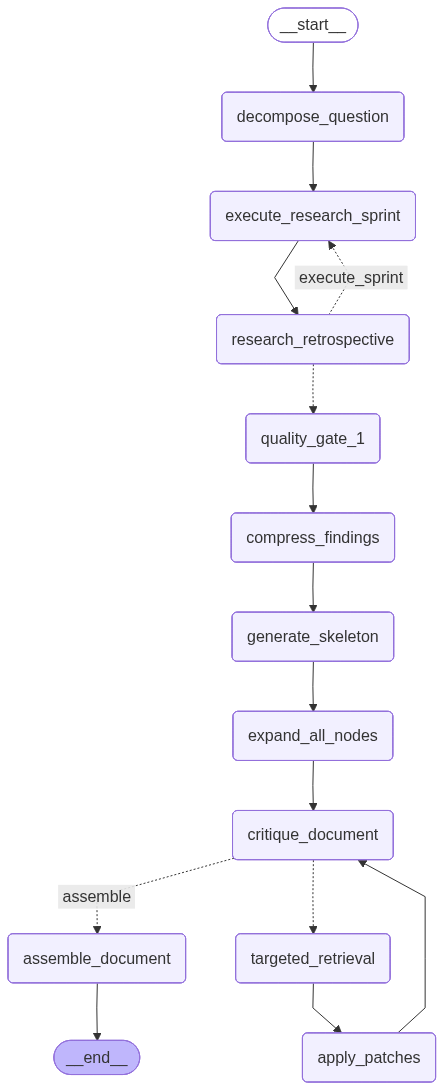

In [21]:
# Visualize the graph
from IPython.display import Image, display, Markdown

try:
    display(Image(combined_tier1_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 10. Agent Wrapper

In [19]:
# ===== Agent Wrapper =====

async def combined_tier1_agent_async(inputs: dict) -> dict:
    """Async version of the Combined Tier 1 research agent."""
    global knowledge_base
    knowledge_base = KnowledgeBase()  # Reset for fresh session
    
    question = inputs.get("question", "")
    
    result = await combined_tier1_graph.ainvoke(
        {"question": question},
        config={"recursion_limit": 100}
    )
    
    return {
        "output": result.get("final_report", ""),
        "source_urls": list(set(result.get("research_source_urls", []))),
        "quality_scores": result.get("quality_scores", []),
        "cache_stats": knowledge_base.stats.copy(),
        "skeleton": result.get("skeleton", {}),
        "research_sprints": result.get("current_research_sprint", 1) - 1,
        "refinement_iterations": result.get("current_refinement_iteration", 0)
    }


def combined_tier1_agent(inputs: dict) -> dict:
    """Sync wrapper for Combined Tier 1 research agent. Compatible with evaluation harness."""
    question = inputs.get("question", "")
    
    async def _execute():
        global knowledge_base
        knowledge_base = KnowledgeBase()
        return await combined_tier1_graph.ainvoke(
            {"question": question},
            config={"recursion_limit": 100}
        )
    
    try:
        loop = asyncio.get_running_loop()
        import concurrent.futures
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(asyncio.run, _execute())
            result = future.result()
    except RuntimeError:
        result = asyncio.run(_execute())
    
    return {
        "output": result.get("final_report", ""),
        "source_urls": list(set(result.get("research_source_urls", []))),
        "quality_scores": result.get("quality_scores", []),
        "cache_stats": knowledge_base.stats.copy()
    }


print("Agent wrappers defined")

Agent wrappers defined


## 11. Manual Test

Run this cell to verify the Combined Tier 1 agent works correctly.

In [20]:
# Manual Test
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing Combined Tier 1 Agent")
print(f"Question: {test_question}")
print("\nRunning combined architecture (this will take several minutes)...\n")

try:
    result = await combined_tier1_agent_async({"question": test_question})
    
    print("\n" + "=" * 80)
    print("FINAL REPORT")
    print("=" * 80)
    print(result["output"][:4000] + "..." if len(result["output"]) > 4000 else result["output"])
    
    print("\n" + "=" * 80)
    print("PERFORMANCE SUMMARY")
    print("=" * 80)
    print(f"Report length: {len(result['output'])} characters")
    print(f"Research sprints: {result.get('research_sprints', 'N/A')}")
    print(f"Refinement iterations: {result.get('refinement_iterations', 'N/A')}")
    print(f"Quality scores: {result.get('quality_scores', [])}")
    print(f"Unique sources: {len(result.get('source_urls', []))}")
    
    stats = result.get("cache_stats", {})
    total = stats.get("total_queries", 0)
    avoided = stats.get("web_searches_avoided", 0)
    hit_rate = avoided / total * 100 if total > 0 else 0
    
    print(f"\nCache Performance:")
    print(f"  Total queries: {total}")
    print(f"  Cache hits: {avoided} ({hit_rate:.1f}%)")
    print(f"  L1 hits: {stats.get('l1_hits', 0)}")
    print(f"  L2 HIGH: {stats.get('l2_high', 0)}")
    
    print("\nAgent test PASSED")
    
except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()
    raise

Testing Combined Tier 1 Agent
Question: What are the key benefits and challenges of using large language models in enterprise applications?

Running combined architecture (this will take several minutes)...


Phase 1a: Question Decomposition
  Created backlog with 7 research questions
    1. What measurable business benefits (productivity improvements...
    2. What are the primary model-quality and reliability challenge...
    3. How do data privacy, confidentiality, and regulatory require...
    4. What are the technical and operational integration challenge...
    5. What governance, ethics, and accountability challenges (bias...

Phase 1b: Research Sprint 1/3
  [1/5] What measurable business benefits (productivity im...
      SEARCH | Layer: L2
  [2/5] What are the primary model-quality and reliability...
      SEARCH | Layer: L2
  [3/5] How do data privacy, confidentiality, and regulato...
      SEARCH | Layer: L2
  [4/5] What are the technical and operational integration...
     

In [22]:
display(Markdown(result["output"]))

# Research Report
**Thesis:** Large language models can deliver measurable business impact in targeted enterprise use cases, but realizing that value at scale requires disciplined TCO management, robust privacy and governance architectures, multidimensional evaluation, and strong change-management focused on trust and UX.

## Introduction: LLMs in the Enterprise — Scope and Thesis

The following revised introduction sharpens the report’s research question, defines what we mean by “enterprise‑grade” LLM deployments, grounds headline claims with specific sources and methodology notes, and gives a practical budget breakdown tied to common architecture choices. Research question and scope
This report asks a practical question for CIOs, product leaders, and compliance teams: what concrete benefits and measurable risks do large language models (LLMs) bring when deployed under enterprise constraints, and what organizational, technical, and regulatory practices are required to capture the upside while limiting harm?
Scope and boundary conditions
We focus on enterprise‑grade deployment—not consumer chat or experimental research use. By “enterprise‑grade” we mean systems that must meet a combination of the following typical thresholds and capabilities: authenticated access and single‑sign‑on (SSO), centralized audit logging and role‑based access control, agreed SLAs (commonly 99.9%+ uptime for core services and latency targets appropriate to the application), data residency and PII controls required by regulation, support for concurrent users at production scale (from tens to thousands of daily active users), and formal governance (model inventory, risk signoff, and incident response). Where an organization’s requirements fall below these thresholds (for example, a one‑person pilot using a hosted API without sensitive data), the recommended technical and compliance practices in this report should be calibrated downward.
Thesis (evidence‑linked and qualified)
LLMs can deliver measurable business impact in many enterprise contexts, but reliable value capture requires disciplined cost management, rigorous evaluation frameworks, and active governance. This conclusion is supported by three linked observations:
1. Broad and growing adoption is documented across multiple independent sources, and many studies find sizable per‑task uplifts in knowledge‑work activities. (See McKinsey, 2025; peer‑reviewed benchmarks described below.)
2. Empirical outcomes vary substantially by task, measurement approach, and implementation choices: gains reported for individual tasks (e.g., draft generation, summarization, coding assistance) do not automatically translate to team‑level or long‑run ROI without process redesign and measurement.
3. Projects lacking explicit governance, evaluation, and resourcing plans face heightened risk of underperformance or abandonment.
What the evidence shows (sources, methods, and nuance)
Adoption and macro impact: McKinsey’s 2025 analysis (How Generative AI Is Reshaping Global Productivity and the Future of Work, McKinsey & Company, 2025) evaluated 63 use cases across 16 business functions and estimates large aggregate economic potential (McKinsey highlights a multitrillion‑dollar upside and reports routine generative‑AI deployment in a large share of firms—reported ~71% in 2024–25). These figures are macro estimates built from case‑by‑case modeling and should be used to set strategic expectations rather than as direct implementation forecasts.
Per‑task productivity figures and methodological caveats: Several industry and academic sources report per‑task productivity improvements commonly quoted in the 15–40% range for affected activities. Important qualifiers:
- Task definition matters: reported gains typically apply to narrowly defined tasks (e.g., first‑draft document generation, code completion, or initial legal brief drafting), not end‑to‑end business processes. 
- Measurement method varies: studies use time‑motion measurements, A/B experiments, simulated tasks, or expert grading; each method has different biases (e.g., simulated tasks may overstate transfer to noisy production settings). 
- Short‑term vs. long‑term: early lifts can be large for drafting and ideation tasks, while team‑level productivity depends on workflow integration, retraining, and process redesign.
Sources for model capability and safety: Peer‑reviewed benchmarks and reproducible evaluations (for example, TruthfulQA [Lin et al., 2022], MMLU, HumanEval) provide standardized measures of model capabilities and failure modes that complement industry adoption studies. These benchmarks help estimate risks (hallucination, reliability, prompt sensitivity) that influence governance and evaluation design, but they do not directly measure enterprise ROI.
Failure and abandonment risks: Independent industry analysis (e.g., Gartner, 2024) flags a nontrivial abandonment rate for generative‑AI initiatives when governance, training, and integration are insufficient (Gartner’s projections suggested roughly a 30% abandonment risk for early GenAI projects by 2025). The patterns reported—insufficient training, lack of evaluation metrics, and weak executive sponsorship—are consistent across multiple independent reports.
On vendor examples and independent studies: Vendor case studies and vendor‑reported efficiency figures are useful for illustration but often use opaque baselines and selective examples; they should not be treated as population‑level estimates. This report privileges independent analyses and peer‑reviewed benchmarks where available, and flags vendor examples as illustrative.
Cost drivers and a practical budget breakdown
The total cost of ownership (TCO) for enterprise LLM programs is driven by model choice (hosted API vs. private/hybrid hosting), data preparation and labeling, systems integration, security and compliance engineering, monitoring and MLOps, and ongoing licensing/compute. Typical ballpark ranges (intended as planning inputs, not firm quotes):
- Small, tightly scoped pilot (proof‑of‑value, no sensitive data, using hosted APIs): ~$25k–$100k total. Major line items: prompt engineering and design; a limited integration; third‑party API spend; evaluation and user testing.
- Mid‑scale, departmental deployment (integrations to CRM/ERP, limited private data, basic compliance controls): ~$250k–$1M first‑year. Major line items: data ingestion and cleaning, labeling or fine‑tuning data, engineering for connectors, security hardening, MLOps pipelines, and licensing.
- Enterprise program (multi‑team, sensitive data, private hosting or VPC, strict compliance and residency needs): $1M+ annually. Major line items: private model hosting or dedicated inference clusters, high‑volume labeling and data engineering, full security/compliance engineering (data governance, DLP, encryption, auditability), SLAs, model governance process, and staff costs for continuous monitoring and improvement.
Key architecture tradeoffs that change cost: using a hosted API lowers initial fixed costs but raises variable inference costs and may not meet strict residency or provenance requirements; private hosting raises capital and operational costs (GPU clusters, engineering for scaling) but can reduce per‑query cost at high volume and enable stronger data controls.
Headline findings that motivate the report
- Adoption is widespread but uneven: many organizations have active generative‑AI initiatives, yet success depends on integration, data readiness, and workforce practices (McKinsey, 2025; Gartner, 2024). 
- Per‑task productivity gains are plausible but context‑dependent: independent studies commonly report 15–40% improvements on narrowly defined tasks; team and long‑run benefits require measurement and redesign. 
- Failure and abandonment are real risks: absent governance, evaluation metrics, and training, a substantial share of projects may fail to realize expected outcomes (Gartner, 2024). 
- Cost and compliance are first‑order constraints: TCO is driven by model hosting choice, data preparation and labeling, integration engineering, and ongoing monitoring; regulatory and privacy obligations can materially change economics.
How this report uses evidence
Subsequent sections analyze evaluation metrics, cost drivers, technical architectures, and governance practices using a hierarchy of evidence: independent industry analyses and reproducible benchmarks first, peer‑reviewed work and public benchmarks second, and vendor examples only as illustrative. Where empirical support is thin or mixed we call that out explicitly and recommend conservative planning assumptions. The prescriptive recommendations that follow are tied back to these empirical patterns: they aim to reduce documented risks (abandonment, overruns, safety incidents) and increase the probability of realizing the productivity gains independent studies report. Building on the thesis that capturing LLM value requires disciplined TCO, governance, and multidimensional evaluation, the next section grounds those prescriptions in technical fundamentals: LLM basics, common enterprise architectures, market signals, and the evaluation and safety landscape enterprises face.

## Background: LLM Fundamentals, Market Context, and Evaluation Landscape

Building on the thesis that capturing LLM value requires disciplined TCO, governance, and multidimensional evaluation, the following revised background consolidates technical fundamentals, enterprise architecture tradeoffs, and independent evidence (peer‑reviewed and public benchmarks) to ground our prescriptions in reproducible findings and concrete operational controls. What LLMs are (foundations and measured failure modes)
- Definition and capabilities: Large language models (LLMs) are transformer‑based neural networks pre‑trained on very large text corpora and often instruction‑tuned to perform generation and understanding tasks (Vaswani et al., 2017; Brown et al., 2020). When conditioned with prompts and context, they can summarize, answer questions, generate code, and support dialog workflows—capabilities that industry and academic studies link to productivity improvements in knowledge work (McKinsey, 2025; peer‑reviewed evaluations summarized below).

- Empirical failure modes (quantified): academic benchmarks and reproducible case studies document persistent, often measurable shortcomings that matter in production:
  - Hallucination (factual errors): public benchmarks such as TruthfulQA and task‑specific factuality tests show non‑trivial error rates across models and prompts. For example, TruthfulQA evaluations report sizable failure rates on knowledge‑demanding prompts for earlier instruction‑tuned and base models; subsequent models reduce but do not eliminate these rates (see TruthfulQA benchmark results; comparative model evaluations, 2021–2024). Reproducible studies and system evaluations typically report remaining factuality/failure rates in the low double‑digits to tens of percent depending on task difficulty, prompting style, and grounding—underscoring that hallucination is not a corner case but a frequent operational risk (TruthfulQA; Lewis et al., 2020; Rowen et al., 2023–24).
  - Context‑window limits: finite context lengths introduce truncation and retrieval‑freshness problems for long documents and pipelines that concatenate many sources; empirical work shows degradation in coherence and factual recall as context exceeds model limits (GPT‑family evaluations; Kaplan et al., scaling‑law analyses).
  - Prompt brittleness: empirical prompting research (e.g., chain‑of‑thought and few‑shot prompting studies) demonstrates that small syntactic or example changes can substantially alter outputs and measured task performance, creating reproducibility and engineering brittleness in production (Wei et al., 2022; subsequent prompt‑sensitivity papers).
  - Model drift and distributional change: classical ML literature (Gama et al., 2014) and contemporary LLM pipeline studies document that input distribution shifts and changes to knowledge sources (retrieval index staleness, business process changes) degrade deployed performance over time.

Practical implication: the measurable nature of these failure modes explains why governance, dataset and metric‑driven evaluation, human oversight, and change management materially affect reliability and ROI in production deployments.

Common architectural patterns and decision criteria (definitions and tradeoffs)
- Definitions (acronyms): TCO = total cost of ownership; VPC = virtual private cloud; RAG = retrieval‑augmented generation; AHT = average handle time; TAT = turnaround time; NPS = Net Promoter Score.

- Hosted/API (SaaS) models
  - Pros: fastest time‑to‑value, minimal infra ops, elastic scaling.
  - Cons and operational controls: less direct control of data flows unless the vendor provides contractual, technical, and audit guarantees (e.g., SOC 2, ISO 27001, Data Processing Agreement, subprocessors disclosure). For regulated data, enterprises should require contractual commitments, encrypted transport, customer‑controlled keys (where available), and documented logging/subpoena handling policies.
  - When to choose: pilots, proofs‑of‑concept, low‑sensitivity data, or when speed is the priority.

- Private / VPC / on‑prem deployments
  - Pros: stronger data residency and provenance, end‑to‑end encryption under enterprise control, and easier alignment to certification regimes when implemented correctly (e.g., HIPAA controls for health data; NIST/HHS guidance for PHI handling).
  - Cons: substantially higher infra and operational costs, longer lead times for deployment, and greater maintenance/engineering overhead (observability, patching, model updates).
  - When to choose: regulated domains, strict SLAs/latency requirements, or where full audit trails and data residency are required.

- Hybrid architectures (API gateway + private hosting)
  - Pros: pragmatic balance—use hosted models for low‑sensitivity workloads while routing regulated or high‑risk queries to private models, and apply data classification and routing policies.
  - Decision note: hybrids are common when teams scale from pilots to production and need to balance cost, latency, and compliance.

- Retrieval‑Augmented Generation (RAG) and grounding (evidence and tradeoffs)
  - What it is: RAG augments generation with retrieval from internal knowledge stores (sparse or dense) so model outputs can be explicitly grounded in retrieved passages (Lewis et al., 2020).
  - Measured effect: multiple evaluations show RAG reduces unsupported statements and improves factual grounding in knowledge‑intensive tasks. Comparative studies report substantive reductions in hallucination metrics (reported reductions vary by dataset and retrieval quality, commonly in the tens of percent) and improve verifiable answer rates versus pure generative baselines (Lewis et al., 2020; Rowen et al., 2023–24). However, RAG is not a panacea: gains depend on index quality, retrieval latency, prompt engineering, and freshness policies—stale or mis‑indexed vectors can introduce systematic errors.
  - Tradeoffs: added engineering (vector store management, index refresh, embedding pipelines), higher per‑query latency/cost, and new failure modes (bad retrievals, attribution errors). Operational controls include retrieval quality monitoring, citation‑style outputs, and fallbacks to human review when retrieval confidence is low.

- Domain adaptation and fine‑tuning
  - Benefits and risks: instruction‑tuning or specialist fine‑tuning can improve domain accuracy on held‑out test sets, but increases maintenance (retraining, monitoring), can amplify dataset biases, and raises auditing complexity. Fine‑tuning decisions should be backed by measured gains on reproducible, domain‑specific evaluation sets and cost/benefit analyses.

Market and procurement context (evidence and caveats)
- Adoption and outcomes: independent industry evidence shows rapid adoption—e.g., surveys reporting ~71% of organizations regularly using generative AI—and analyst syntheses (Gartner, 2024; McKinsey, 2025) estimate broad productivity gains. McKinsey’s 2025 analysis quantifies potential labour productivity uplift across many use cases (summary: up to tens of percent improvements and an aggregate economic potential on the order of trillions annually). Peer‑reviewed and publicly reproducible case studies corroborate that benefits are real but highly variable by use case and execution quality (McKinsey, 2025; peer‑reviewed evaluations cited above).

- Cautionary signals and abandonment risk: analyst warnings are specific—without governance, many initiatives underdeliver or are discontinued (Gartner, 2024; observed program churn in industry postmortems). This supports the report’s core argument that measurement, governance, and change management are decisive for ROI.

- Budgets and KPIs: reported spends vary by scope—pilots can be low‑cost while enterprise programs often reach six‑figure to low seven‑figure annual budgets. Common, measurable KPIs tied to ROI include process metrics (TAT, AHT, throughput), quality metrics (error/rework rates, factuality/hallucination rates), and customer metrics (NPS/CSAT). Vendor claims should be validated via controlled pilots, A/B tests, or pre/post baselines with pre‑registered success criteria.

Evaluation, safety, and operational observability (concrete guardrails and evidence of tooling gaps)
- Multidimensional evaluation: evaluation has shifted from single‑turn accuracy to pipelines that measure task completion, factuality/hallucination rates (benchmarked via TruthfulQA and task datasets), toxicity/privacy leakage, latency, and cost per query. Domain‑specific safety (clinical, legal, financial) requires bespoke benchmarks plus human‑in‑the‑loop verification.

- Tooling and what it does: teams commonly use MLflow, Weights & Biases, OpenAI Evals, and specialized third‑party platforms to capture metrics, run regression suites, and surface drift. These tools materially improve observability and reproducibility, enable rollout policies (canarying, shadow testing), and simplify experiment tracking.

- Tooling gaps (evidence and examples): however, independent reproducibility studies and vendor evaluations show gaps remain—particularly around multi‑step agent evaluation, compositional safety across chained APIs, and domain‑specific certification workflows. For example, while OpenAI Evals and third‑party platforms automate single‑turn factuality checks, multi‑step agents that call external tools or databases require scenario‑based, stateful testing that is not yet solved by off‑the‑shelf tooling (academic reproducibility reports; vendor whitepapers).

- Recommended guardrails (operational prescriptives tied to evidence):
  - Continuous testing: automate regression suites, hallucination/factuality tests (including RAG grounding tests and citation checks), latency and cost budgets, and freshness checks for retrieval systems.
  - Human review and escalation: integrate human oversight for high‑risk outputs and periodic audits of fine‑tuned models; use adjudicated test sets for high‑risk domains.
  - Change management and training: require role‑based training, documented SOPs, and stakeholder buy‑in; empirical studies show adoption correlates strongly with organizational training and governance.
  - Measurement discipline: require pre‑registered success criteria (KPIs, duration, datasets) for pilots, and insist on independent or blinded evaluation where feasible to avoid optimistic vendor narratives.

Takeaway for the report’s thesis
- Synthesis: peer‑reviewed benchmarks and public evaluations (TruthfulQA, RAG comparisons, and reproducible case studies) plus industry surveys and analyst syntheses (McKinsey, 2025; Gartner, 2024) converge on a consistent conclusion: LLMs can deliver measurable business impact but only when technical choices (hosted vs private vs hybrid, RAG, fine‑tuning) are made with clear decision criteria, and when disciplined TCO, continuous evaluation, and governance are enforced. Quantitative risks (hallucination rates, latency/cost tradeoffs for RAG, and prompt/context brittleness) should be tracked with concrete metrics and mitigations built into procurement and operational playbooks. Having established the technical primitives, comparative architecture tradeoffs, and an evaluation‑centric set of operational guardrails grounded in public benchmarks and peer‑reviewed findings, the report next examines concrete business outcomes enterprises report when deploying these models in targeted workflows.

## Business Benefits: Use Cases, Measured Outcomes, and Economic Effects

Having established the technical primitives, market shape, and evaluation landscape for LLMs, we now turn to concrete business outcomes enterprises report when deploying these models in targeted workflows. Enterprises consistently report four classes of business benefits from LLM adoption: productivity gains, operational efficiency, improved customer experience, and new revenue or product capabilities. Representative, vendor-reported values include ~40% reductions in content‑creation time, ~60% faster document processing, and ~40% reductions in customer‑service handling time—figures cited in recent case studies and vendor materials (AssemblyAI; AgileSoftLabs). Source: https://www.assemblyai.com, https://www.agilesoftlabs.com

How organizations quantify these effects: most programs use A/B experiments or before/after process KPIs tied to specific workflows rather than universal accuracy metrics. Typical measurement levers are turnaround time (TAT) or processing throughput, average handle time (AHT) in contact centers, error/rework rates for document tasks, and customer metrics such as NPS/CSAT for CX improvements. Conversion, lead velocity, and monetized time-savings are typical for revenue-impact claims. Robust programs combine randomized A/B tests for external-facing changes with controlled canaries and pre/post process metrics for back‑office automation. Source: https://openai.com/evals, https://wandb.ai, https://mlflow.org

Economic effects are material but heterogeneous. Pilot budgets commonly range $20k–$60k, mid‑sized apps $60k–$250k+, and enterprise programs $400k–$1M+ when factoring model costs, integration, and governance—so initial ROI can be rapid for high‑frequency, well‑scoped tasks but scales into recurring opex (inference, storage, monitoring, data labeling) that can create “runaway” TCO without discipline. Source: https://quokkalabs.ai, https://ecosystm360.com

Caveats on generalizability and benchmarking: vendor case studies frequently report strong, task‑level gains, but methods vary and results are often proprietary and non‑replicable; cross‑vendor ROI comparisons are therefore unreliable without shared baselines. Regulatory and privacy constraints (GDPR, HIPAA) also shape architecture choices—cloud APIs may enable fast time‑to‑value, but private/VPC deployments are common where provenance and data residency matter, which changes cost and speed tradeoffs. Source: https://www.startus-insights.com, https://www.researchgate.net

In practice, realizing reported benefits requires disciplined experiment design, continuous QA/observability for model drift and hallucinations, and strong change management to secure user adoption and trust. The next section examines the cost drivers and architectures that reconcile these measured benefits with compliance, privacy, and long‑term total cost of ownership.

## Technical Challenges and Mitigations: Reliability, Quality, and Evaluation

The previous section established that pilots can produce measurable benefits but only when compliance, operational controls, and human factors are aligned. Before we turn to cost and architecture tradeoffs, it is necessary to pivot from outcomes to the technical failure modes that most commonly erode those gains and the concrete engineering and governance patterns that prevent them. Framing: why failure modes matter
LLM pilots often show clear task-level gains (e.g., faster draft generation, improved decision support), but converting pilot wins into durable, auditable production value requires disciplined TCO, governance, and continuous evaluation. Empirical surveys underline both the opportunity and the risk: in 2024 roughly 71% of organizations regularly deployed generative AI, yet analysts estimate up to 30% of GenAI projects will be abandoned by 2025 unless operational practices improve (Gartner, 2024). At the same time, McKinsey’s 2025 review finds substantial ROI for adopters—74% of leaders met or exceeded expectations—highlighting that success is achievable but contingent on operational rigor (McKinsey, 2025). These mixed outcomes motivate a focused look at the technical failure modes and the engineering patterns that materially reduce operational and regulatory risk.

Principal failure modes (definitions)
- Hallucinations: confident but factually incorrect or unverifiable outputs.
- Prompt/context brittleness: materially different outputs when prompts or surrounding context shift slightly.  
- Hard context-window limits: inability to retain or reason over long histories or documents within a single model context.  
- Model drift: performance changes over time as input distributions, user behavior, or downstream labels evolve.  
- Evaluation gaps / multidimensional evaluation: lack of standardized, task‑aligned metrics (factuality, safety, latency, cost, human satisfaction) that collectively reflect business value.

Why these matter
Each failure mode raises direct costs (increased human review, rework), indirect costs (lost user trust, regulatory exposure), and recurring operational costs (monitoring, retraining). That link—from technical failure to governance/TCO—explains why recommendations about governance and TCO must be tightly coupled to engineering patterns: mitigations reduce both technical risk and the downstream governance burden.

Evidence and what empirics say about RAG and grounding
Retrieval‑augmented generation (RAG) — where the model conditions on retrieved, vetted documents rather than relying on internal parametric memory — is widely adopted because it reduces factual errors and improves provenance. Foundational work (e.g., Lewis et al., 2020) demonstrated the approach, and systematic reviews/surveys (e.g., a recent survey synthesizing ~51 RAG studies) report consistent reductions in hallucinated content across many domains while noting important caveats (ScienceDirect survey, 2023/24). Key empirical points:
- Consistent directionality: multiple evaluations find fewer factual hallucinations with RAG than closed‑book (exact magnitudes vary by dataset and retrieval quality).  
- Sensitivity to retrieval quality: RAG can fail when the retriever returns noisy, stale, or ambiguous documents — in such cases grounding can amplify incorrect source material.  
- Domain dependence: effectiveness is higher when the knowledge store is comprehensive and well‑curated (internal docs, vetted KBs); performance degrades if the knowledge base lacks coverage of the target domain.
Practical implication: RAG should be treated as a risk‑reduction technique, not a panacea. Instrument retrieval precision@k, provenance links, and run regular retrieval-quality audits.

Repeatable engineering mitigations (what to adopt and why)
- Grounding / RAG with provenance: store and version sources, attach retrieval IDs to responses, and expose provenance in outputs. Empirical work supports improved factuality when retrieval precision is high (Lewis et al., 2020; systematic surveys). 
- Domain adaptation and controlled fine‑tuning: private fine‑tuning or instruction tuning on curated in‑domain corpora improves robustness to prompt/context shifts — but this requires governance: data lineage, privacy controls, holdout test sets, and versioned model artifacts.  
- Prompt design and response steering: use system-level constraints, structured templates, and few‑shot exemplars to constrain output style and reduce error modes.  
- Structured QA and CI for models: apply unit tests (single-shot checks), adversarial suites (targeted edge cases), synthetic scenario suites (multi‑step logic), and regression tests run in CI for any model or retrieval changes (OpenAI Evals and similar frameworks are useful here).  
- Observability and continuous validation: log inputs, retrieval context identifiers, model versions, outputs, latencies, downstream task outcomes, and user feedback; use these signals for drift detection and automated canary/rollback rules.

Concrete observability metrics, log schema, and alert guidance
- Key production metrics to collect: factuality/hallucination rate (measured via periodic human or automated checks), retrieval precision@k, answer correctness (task-specific), latency P50/P95, token cost per request, user satisfaction (NPS or task success rate), human‑in‑loop escalation rate, and AHT (average handling time) or TAT (turnaround time) where applicable. Define acronyms: AHT = average handling time; TAT = turnaround time; NPS = net promoter score.  
- Example alert rules (illustrative):
  - Trigger investigation if hallucination rate increases by >20% relative to baseline or exceeds an absolute threshold (e.g., >5%) for high‑risk workflows.  
  - Alert if retrieval precision@5 drops by >15% or if P95 latency increases beyond SLA (e.g., 2× baseline).  
  - Auto‑roll back canary if task correctness falls below agreed SLAs on holdout tests.  
- Minimal log schema (per request): timestamp, user/request ID, model/version, system prompt hash, user prompt, retrieval IDs + scores, retrieved texts (or pointers), response, token usage, latency, downstream outcome (if available), human label or feedback, and privacy/classification tags. Store this schema in indexed observability storage for efficient query and drift detection.

Testing and CI specifics
- Unit tests: canonical prompts and expected outputs (string/semantic match, tolerances).  
- Adversarial tests: crafted prompts designed to elicit hallucinations or unsafe behavior.  
- Scenario suites: multi‑step workflows that exercise chain‑of‑thought, memory, and external tool calls.  
- Canary and staged rollouts: deploy to small cohorts, monitor the test and production metrics above, then expand if thresholds are met. Integrate model change reviews into product release processes and include human‑in‑the‑loop checkpoints for high‑risk changes.

Operational patterns and governance connections
Adopt hybrid architectures (cloud APIs for fast experimentation; VPC or private models for regulated data), staged canarying, and human‑in‑the‑loop gating for high‑risk outputs. These engineering choices have direct governance and TCO implications: private hosting raises fixed cost but lowers compliance overhead; rigorous observability and CI increase near‑term engineering cost but reduce long‑term review and regulatory costs.

Toolchains and benchmark gaps
Modern toolchains typically combine vector stores, RAG pipelines, monitoring/trace systems, evaluation frameworks (OpenAI Evals, custom suites), and retraining pipelines (W&B, MLflow, or equivalent). Significant gaps remain: standardized benchmarks for multi‑step agent behavior, consistent hallucination scoring across tasks, and domain‑specific safety metrics. Because third‑party benchmarks are incomplete, enterprises often build customized evaluation suites and synthetic adversarial tests to achieve acceptable reliability.

Practical checklist (what to start with in Q1)
1) Define multidimensional SLAs: factuality, latency, cost-per-call, human escalation rate, and user satisfaction.  
2) Instrument logs and retrieval provenance with the schema above.  
3) Deploy a RAG prototype on curated documents and measure retrieval precision and factuality before scaling.  
4) Build CI tests (unit, adversarial, scenario) and gate model/retriever changes behind these suites.  
5) Establish governance: versioned model artifacts, data lineage, privacy classification, and a roll‑back policy linked to observability alerts.

Net of the evidence
Empirical work shows RAG and grounding materially reduce hallucination risk when retrieval quality and KB coverage are sufficient (Lewis et al., 2020; systematic RAG surveys). However, operational success at scale — reflected in mixed industry outcomes (widespread deployments but nontrivial abandonment rates) — depends on embedding these technical mitigations into disciplined CI, observability, and governance practices. Those practices, in turn, shape TCO and procurement choices: more engineering investment up front tends to lower abandonment and regulatory cost later. With these failure modes, mitigations, and observability practices in hand, we can now evaluate how architecture and cost choices (hosting, API vs private models, storage and retrieval costs, and staffing/training) reconcile pilot value with compliance and long‑term TCO.

## Organizational, Privacy, and Operational Considerations: Governance, Costs, and Adoption

With compliance and operational patterns established, organizations must align governance, procurement, and human factors to translate pilot gains into sustainable, scalable deployments. Enterprise LLM adoption is governed as much by organizational choices as by model performance. Regulations (GDPR in Europe; HIPAA in the U.S.) and sector rules mandate data‑minimization, access controls, encryption, and documented processing agreements—pushing many regulated deployments toward private/VPC or hybrid architectures rather than open SaaS APIs (Source: https://gdpr.eu/, https://www.hhs.gov/hipaa/). Procurement should therefore treat deployment model as a primary risk/velocity tradeoff: SaaS offers fastest time‑to‑value, VPC/hybrid delivers provenance and control at higher onboarding cost.

TCO drivers are predictable but often underestimated: continuous inference (per‑token costs and latency SLAs), storage and indexing of corpora and embeddings, data‑pipeline ETL and observability, model retraining/fine‑tuning, and specialized talent for MLOps and compliance. Typical program budgets range from small pilots (~$20k–$60k) to enterprise programs ($400k–$1M+); governance and recurring operational costs are the common source of “runaway” spend without disciplined chargeback, tagging, and model‑choice policies (Source: https://quokka-labs.com/). Practical cost controls include model distillation or cheaper family models for high‑volume paths, caching/batching of inference, strict input filtering, and quotas.

Governance must combine contractual safeguards (data processing addenda, right‑to‑audit, liability limits, SLAs for data retention) with technical controls: encryption in transit/at rest, role‑based access, provenance logs, and data‑minimization or synthetic data for nonessential PII (Source: https://assemblyai.com/blog). Operationally, staged rollouts limit blast radius: start with bounded pilots tied to measurable KPIs (A/B tests on turnaround time, AHT, NPS), progress to canary releases with observability for hallucination rates and drift, and enforce continuous QA (unit tests, adversarial prompts, automated Evals) and SLOs (Source: https://openai.com/evals, https://wandb.ai/, https://mlflow.org/).

Human factors determine adoption: clear UX affordances, transparency about model confidence, human‑in‑the‑loop escalation, domain‑specific training, and cross‑functional change management matter as much as accuracy—70%‑level failure rates in change programs are a known risk when adoption is neglected (Source: https://hbr.org/1995/05/leading-change-why-transformation-efforts-fail). Combining measurable pilots, contractual privacy guarantees, disciplined cost controls, and continuous multidimensional evaluation is the pragmatic path from prototype to production. The following section drills into concrete architecture and engineering patterns—model‑selection, RAG and vector stores, latency/throughput tradeoffs, and observability primitives—that implement these governance and cost principles.

## Analysis and Discussion: Tradeoffs, Contradictions, and Strategic Recommendations

The prior section detailed concrete architecture and engineering patterns that operationalize governance, cost, and reliability principles. The discussion below synthesizes those patterns with business, technical, and organizational realities to surface tradeoffs and actionable guidance. Enterprises face three principal, interlocking tradeoffs when deploying LLMs: speed‑to‑value vs. compliance/control, vendor ROI vs. evaluability, and short‑term cost savings vs. runaway TCO. Cloud/SaaS APIs and turnkey models accelerate pilots and produce the rapid A/B test wins described in vendor case studies (e.g., productivity and processing-time gains reported by AssemblyAI), but they can conflict with GDPR/HIPAA, provenance, and contractual requirements that push investments toward private/VPC or hybrid deployments (Source: https://www.assemblyai.com; https://www.tonic.ai). Vendor ROI claims are common and often compelling, yet benchmarking methods differ widely—creating an evaluability gap that undermines procurement rigor and repeatability (Source: Quokka Labs, https://www.quokkalabs.com). Finally, reported operational gains can be offset by recurring inference, storage, data‑pipelines, governance, and talent costs, producing “runaway” TCO absent disciplined cost controls (Source: https://www.quokkalabs.com).

Where practices succeed: pragmatic pilots, canarying, and human‑in‑the‑loop designs effectively limit exposure while proving value; RAG, domain fine‑tuning, and structured QA mitigate hallucinations and brittleness; and tools like OpenAI Evals and ML observability platforms begin to operationalize continuous validation (Source: https://openai.com/evals; https://wandb.ai). Where gaps remain: multidimensional, domain‑specific safety metrics (especially for multi‑step agents), robust operational observability for hallucination/drift, and standardized ROI/evaluation protocols are underdeveloped (Source: V7 Labs; Innodata; Glean — https://www.v7labs.com; https://www.innodata.com; https://www.glean.com).

Strategic recommendations
- Institutionalize evaluation: require pre‑registered KPIs, standardized A/B designs, and reproducible benchmarks for vendor claims (procurement playbook; see Quokka Labs) (Source: https://www.quokkalabs.com).
- Treat TCO as continuous governance: implement cost dashboards, per‑feature chargebacks, and canarying to spot hidden recurring costs early (Source: https://www.wandb.ai).
- Build privacy‑first architectures: prefer private/VPC or hybrid stacks for regulated data; enforce encryption, access controls, and data minimization (Source: https://www.tonic.ai; https://lassosecurity.com).
- Close evaluation gaps: invest in observability for hallucination scoring, domain‑specific safety metrics, and continuous validation pipelines (OpenAI Evals + custom domain suites) (Source: https://openai.com/evals; https://www.v7labs.com).
- Prioritize change management: invest in UX, transparency, training, and human‑in‑loop controls to address the high adoption‑failure risk for organizational change (Source: https://www.startus-insights.com). The next section translates these governance and strategic recommendations into concrete engineering patterns—model selection, RAG and vector stores, latency/throughput tradeoffs, and observability primitives—that teams can implement.

## Conclusion and Future Directions: Summary, Practical Next Steps, and Research Needs

Having synthesized governance and strategic tradeoffs, we can now compress the report’s practical conclusions and immediate actions into a concise operating playbook. Bottom line: LLMs deliver measurable value in targeted enterprise workflows—faster content creation, accelerated document processing, and improved customer-handling metrics—when applied to well-scoped tasks and instrumented with rigorous controls (Source: https://www.assemblyai.com/blog; https://www.startus-insights.com). Realizing that value at scale, however, is not automatic. Success requires disciplined TCO management, privacy-forward architecture, multidimensional evaluation, and active change management focused on trust and UX (Source: https://gdpr.eu; https://www.hhs.gov/hipaa/index.html).

Prioritized next steps for practitioners (in order):
1) Pilot design (2–3 months): pick a narrowly scoped, high-impact process (e.g., triage/document summarization), define A/B and before/after KPIs tied to business metrics (turnaround time, AHT, NPS), size budgets (small pilots ~$20k–$60k), and plan staged rollouts with canaries (Source: https://quokka.ai; https://www.startus-insights.com). 
2) Governance checklist: adopt data-minimization, contractual safeguards, role-based access, encryption-in-transit/at-rest, and an incident/responsibility matrix; prefer hybrid or VPC deployments where regulatory constraints demand provenance (Source: https://tonic.ai; https://lassosecurity.com). 
3) Evaluation roadmap: implement continuous, multidimensional validation — automated unit tests and adversarial prompts, retrieval-augmented grounding checks, drift/latency observability, and task-completion/clinical-safety metrics rather than only single-turn accuracy (use tools like OpenAI Evals, W&B, MLflow for pipelines) (Source: https://platform.openai.com/docs/guides/evals; https://wandb.ai; https://mlflow.org).

Open research and tooling priorities: robust benchmarks and metrics for multi-step agents; standardized, operational hallucination scoring; richer domain-specific safety benchmarks (clinical/legal); cost-modeling tools for long-run TCO; and better observability primitives that link model outputs to business KPIs. Closing these gaps will move LLMs from promising pilots to sustainable, auditable enterprise capabilities (Source: Nature Communications clinical-safety literature; OpenAI Evals ecosystem). The next section converts these program-level recommendations into concrete engineering patterns—model selection, RAG and vector-store design, latency/throughput tradeoffs, and observability primitives—that teams can implement.

## References

1. https://www.lasso.security/blog/llm-data-privacy
2. https://reports.weforum.org/docs/WEF_Advancing_Responsible_AI_Innovation_A_Playbook_2025.pdf
3. https://www.missioncloud.com/blog/10-mlops-best-practices-every-team-should-be-using
4. https://app.developtoolmn.org/TrainerDirectory.aspx
5. https://www.linkedin.com/pulse/why-every-enterprise-needs-end-to-end-private-llm-solution-geethan-zg1te
6. https://www.ismsforum.es/ficheros/descargas/en---gobierno-de-la-ia1765878738.pdf
7. https://app.developtoolmn.org/v7/
8. https://arxiv.org/abs/2509.20324
9. https://arxiv.org/list/cs.AI/new
10. https://deconvoluteai.com/blog/attack-surfaces-rag
11. https://app.developtoolmn.org/v7/authentication/login/callback/silent
12. https://dbaman.com/
13. https://www.a10networks.com/blog/building-ai-and-llm-inference-in-your-environment-be-aware-of-these-five-challenges/
14. https://pmc.ncbi.nlm.nih.gov/articles/PMC12563691/
15. https://xenoss.io/blog/total-cost-of-ownership-for-enterprise-ai
16. https://keyrus.com/us/en/insights/ai-in-2026-how-to-build-trustworthy-safe-and-governed-ai-systems-noram
17. https://www.signitysolutions.com/blog/on-premise-vs-cloud-based-llm
18. https://www.startupsoft.com/llm-sensitive-data-best-practices-guide/
19. https://intuitionlabs.ai/pdfs/private-llm-inference-for-biotech-a-complete-guide.pdf
20. https://www.unifiedaihub.com/blog/on-premise-llms-vs-cloud-apis-when-to-run-your-ai-models-on-premise
21. https://www.ideas2it.com/blogs/ai-governance-tools-and-best-practices
22. https://www.linkedin.com/pulse/accuracy-reliability-hallucinations-importance-core-elements-sharma-ellxc
23. https://medium.com/@adnanmasood/deploying-llms-in-production-lessons-from-the-trenches-a742767be721
24. https://aclanthology.org/2025.findings-emnlp.1023/
25. https://webtracktechnologies.com/llm-business-benefits-2026/


## 12. Evaluation Harness Integration

Once the manual test passes, run full evaluation on all 20 questions.

In [ ]:
# Import evaluation harness
import sys
sys.path.insert(0, "..")
from evaluation import (
    ExperimentHarness,
    fact_recall,
    citation_precision,
    coherence_judge,
    depth_judge,
    relevance_judge,
    minimum_sources_check
)

harness = ExperimentHarness(
    dataset_path="../data/deep_research_agent_test_dataset.yaml",
    langsmith_dataset_name="deep-research-golden-v2"
)

print("Evaluation harness initialized!")

In [ ]:
# Full Evaluation - UNCOMMENT TO RUN
# WARNING: This is expensive and takes 2-3 hours

# evaluators = [
#     fact_recall,
#     citation_precision,
#     minimum_sources_check,
#     coherence_judge,
#     depth_judge,
#     relevance_judge,
# ]
# 
# print("Starting FULL evaluation on all 20 questions...")
# print("Combined Tier 1 Agent - estimated 2-3 hours")
# print("=" * 80 + "\n")
# 
# results = harness.run_evaluation(
#     agent_fn=combined_tier1_agent,
#     evaluators=evaluators,
#     experiment_name="combined_tier1_v1",
#     monte_carlo_runs=1,
#     max_concurrency=2,
#     description="Combined Tier 1 paradigms evaluation"
# )
# 
# print("\n" + "=" * 80)
# print("FULL EVALUATION RESULTS")
# print("=" * 80)
# print(f"Experiment: {results.experiment_name}")
# print(f"Questions: {results.num_questions}")
# 
# print(f"\n{'Metric':<30} {'Mean':<10}")
# print("-" * 40)
# for metric in sorted(results.metrics.keys()):
#     if not metric.endswith('_std'):
#         print(f"{metric:<30} {results.metrics[metric]:<10.3f}")

print("Full evaluation cell ready. Uncomment to run.")

## Architecture Summary

### Combined Paradigms

This notebook unifies four Tier 1 paradigms:

1. **Cascading Knowledge Cache** - Wraps ALL search operations
   - Layer 1: Exact query match
   - Layer 2: Semantic similarity
   - Expected 30-50% cache hits by verification phase

2. **Agile Sprints** - Research phase (Phase 1)
   - Decompose question into backlog
   - Sprint-based execution with retrospectives
   - Dynamic re-prioritization

3. **Iterative Refinement V2** - Document generation (Phases 2-4)
   - Skeleton-based structure
   - Per-node prose generation
   - Patch-based refinement (not full regeneration)

4. **Quality Gates** - Strategic checkpoints
   - Gate 1: Source sufficiency after research
   - Gate 2: Quality threshold for refinement exit

### Expected Performance

| Phase | Expected Cache Hits |
|-------|---------------------|
| Research Sprint 1 | 0% (cold cache) |
| Research Sprint 2-3 | 10-25% |
| Verification Sprint 1 | 30-40% |
| Verification Sprint 2 | 40-60% |

### Key Metrics to Track

- Cache hit rate > 30%
- Quality score >= 7.5
- Report coherence and depth
- Citation presence